# Advanced Machine Learning (MScA 32017)

# Linear Regression in Spark MLLib

Yuri Balasanov, &copy; iLykei 2017

## Data format and extraction of results

Data for linear regression in MLLib need to be in the form of DataFrame of `LabeledPoint` records: first element is label, second element is a vector of predictors.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

Create a toy data example.

In [2]:
df = spark.createDataFrame([ \
     (0.0, Vectors.dense(0.0,4.0)), \
     (1.0, Vectors.dense(1.0, 4.0)), \
     (2.0,Vectors.dense(4.0,3.0)), \
     (3.0,Vectors.dense(3.0,1.0))], ["label", "features"])
print(df.take(1))
df.show()

[Row(label=0.0, features=DenseVector([0.0, 4.0]))]
+-----+---------+
|label| features|
+-----+---------+
|  0.0|[0.0,4.0]|
|  1.0|[1.0,4.0]|
|  2.0|[4.0,3.0]|
|  3.0|[3.0,1.0]|
+-----+---------+



Create linear regression object and fit the model.

In [3]:
lr = LinearRegression(maxIter=5, solver="normal")
model = lr.fit(df)

Print fitted model characteristics.

In [4]:
print('Model slopes are: %s' % model.coefficients)
print('Model intercept is %s' % model.intercept)
print('Model parameter t-valueas are: %s' % model.summary.tValues)
print('Model parameters p-values are: %s' % model.summary.pValues)
print('Model parameters standard errors are: %s' % model.summary.coefficientStandardErrors)
print('Model residual number of degrees of freedom is: %s' \
      % model.summary.degreesOfFreedom)
print('Model R2 is: %s' % model.summary.r2)
print('Model explained variance is: %s' %model.summary.explainedVariance)
print('Model residuals are:') 
model.summary.residuals.show()

Model slopes are: [0.314285714286,-0.571428571429]
Model intercept is 2.585714285714292
Model parameter t-valueas are: [1.4969103983674916, -2.1081851067789223, 2.231508943056852]
Model parameters p-values are: [0.3749401481268009, 0.2819659280572473, 0.2682050245645875]
Model parameters standard errors are: [0.20995626366712974, 0.27105237087157574, 1.1587290715367822]
Model residual number of degrees of freedom is: 1
Model R2 is: 0.9485714285714285
Model explained variance is: 1.1857142857142866
Model residuals are:
+--------------------+
|           residuals|
+--------------------+
|-0.30000000000000027|
| 0.38571428571428656|
|-0.12857142857142634|
| 0.04285714285714093|
+--------------------+



To predict create new features:

In [5]:
test0 = spark.createDataFrame([(Vectors.dense(-1.0,2.0),)], ["features"])
test0.show()

+----------+
|  features|
+----------+
|[-1.0,2.0]|
+----------+



Then transform the model with the new features.

In [6]:
model.transform(test0).show()
model.transform(test0).head().prediction

+----------+-----------------+
|  features|       prediction|
+----------+-----------------+
|[-1.0,2.0]|1.128571428571433|
+----------+-----------------+



1.128571428571433

## Example: reading data from csv

Read data from file `regdata.csv` and fit simple regression model.

In [7]:
df = spark.read.csv('./regdata.csv', sep = ',',header=True,inferSchema=True)
print('DataFrame # rows = %s , number of columns = %s' % (df.count(),len(df.columns)))
df.show(10)

DataFrame # rows = 100 , number of columns = 2
+-------------------+------------------+
|                  Y|                 X|
+-------------------+------------------+
|   7.50239901442978|  2.11425512255683|
|   10.5947555769349|  3.10559802345624|
|  -5.78978343620361|  1.46942494775544|
|  -4.63079032995852|-0.560738144475622|
|   7.68382624234006|   4.1761551637828|
|-0.0983449281196052|  2.77233930511998|
|   6.90852273299788|  3.31627239782865|
|   8.07236826022985|  1.86512265760553|
|   7.08664063298932|  2.50618597603128|
|   4.54331129331034|    4.352482385459|
+-------------------+------------------+
only showing top 10 rows



In [8]:
assembler=VectorAssembler(inputCols=["X"],outputCol="feature")
df_ready=assembler.transform(df)
df_ready.show(5)

+-----------------+------------------+--------------------+
|                Y|                 X|             feature|
+-----------------+------------------+--------------------+
| 7.50239901442978|  2.11425512255683|  [2.11425512255683]|
| 10.5947555769349|  3.10559802345624|  [3.10559802345624]|
|-5.78978343620361|  1.46942494775544|  [1.46942494775544]|
|-4.63079032995852|-0.560738144475622|[-0.560738144475622]|
| 7.68382624234006|   4.1761551637828|   [4.1761551637828]|
+-----------------+------------------+--------------------+
only showing top 5 rows



Fit linear regression model using `Y` as response and column `"feature"` as predictor. 

In [9]:
lr = LinearRegression(maxIter=5, regParam=0.0, solver="normal", \
                      featuresCol="feature",labelCol="Y")
model = lr.fit(df_ready)

<font color=red>**Assignment**</font> <br>

<font color=blue>
Check the results of the fit.

Enter code in the following cell to extract the resuots:

Slope = [2.27430797339] <br>
Intercept = -0.33889618627019147 <br>
Coefficients SDE = [0.17337237441771894, 0.6109185962561043] <br>
T-values = [13.118052867600806, -0.5547321498265902] <br>
P-values = [0.0, 0.5803417579866024] <br>
DF = 98 <br>
R2 = 0.6371489981233505 <br>
Explained Variance = 18.55694691884005 <br>
Residuals: <br>
+-------------------+ <br>
|          residuals| <br>
+-------------------+ <br>
|  3.032827917681728| <br>
| 3.8705654163046566| <br>
| -8.792812124916383| <br>
| -3.016602910721759| <br>
|-1.4751405585078148| <br>
+-------------------+ <br>
only showing top 5 rows <br>

In [21]:
print('Slope = %s' % model.coefficients)
print('Intercept= %s' % model.intercept)
print('Coefficients SDE = %s' % model.summary.coefficientStandardErrors)
print('T-values= %s' % model.summary.tValues)
print('P-values= %s' % model.summary.pValues)
print('DF = %s' % model.summary.degreesOfFreedom)
print('R2 = %s' % model.summary.r2)
print('Explained variance = %s' % model.summary.explainedVariance)
print('Residuals')
model.summary.residuals.show(5)

Slope = [2.27430797339]
Intercept= -0.33889618627019147
Coefficients SDE = [0.17337237441771894, 0.6109185962561043]
T-values= [13.118052867600806, -0.5547321498265902]
P-values= [0.0, 0.5803417579866024]
DF = 98
R2 = 0.6371489981233505
Explained variance = 18.55694691884005
Residuals
+-------------------+
|          residuals|
+-------------------+
|  3.032827917681728|
| 3.8705654163046566|
| -8.792812124916383|
| -3.016602910721759|
|-1.4751405585078148|
+-------------------+
only showing top 5 rows



Plot histogram of residuals to see shape of distribution for the residuals.
Transform column of residuals from DataFrame to python list and use function `hist()` from `matplotlib`.

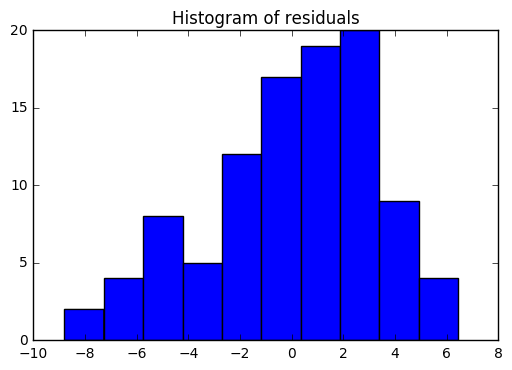

In [22]:
plt.hist(model.summary.residuals.rdd.flatMap(lambda x:x).collect())
plt.title('Histogram of residuals')

## Slice localization example

Use data from Machine Learning (MScA, 31009).
The project is based on [Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science](http://archive.ics.uci.edu/ml/index.php).

The project name is [elative location of CT slices on axial axis Data Set](https://archive.ics.uci.edu/ml/datasets/Relative+location+of+CT+slices+on+axial+axis).

The data contain 384 features extracted from 53,500 CT images from 74 patients.
Each record characterizes a slice of an image.
Each CT slice is described by two histograms in polar space. The first histogram describes the location of bone structures in the image, the second the location of air inclusions inside of the body.
Both histograms are concatenated to form the final feature vector of length 384.
The class output variable is numeric and denotes the relative location of the CT slice on the axial axis of the human body.

The column information:

1:  PatientId: Each ID identifies a different patient <br>
2-241: Histogram describing bone structures <br>
242-385: Histogram describing air inclusions >br>
386: Reference: Relative location of the image on the axial axis (class value). Values are in the range [0; 180] where 0 denotes the top of the head and 180 the soles of the feet.

It is important to predict location of the slice using the features because when 2 or more scans are compared or in general it is necessary to navigate to a certain part of the body, the whole scan (about 1 Gb) needs to be loaded over clinical network and then the required slice is usually identified manually.

The data are in the file `slice_Localization/slice_localization_data.csv`.


Create RDD `firstLook` to understand the structure of the file before reading it as DataFrame.

In [ ]:
firstLook=sc.textFile('./slice_Localization/slice_localization_data.csv')
print('Number of rows: %s' %firstLook.count())
print('Row 1:')
print(firstLook.take(2)[0][0:87])
print('Row 2:')
print(firstLook.take(2)[1][0:86])
print('Number of columns: %s' % len(firstLook.first().split(',')))
print(firstLook.first().split(',')[380:386])

The file consists of 53501 string records, the first of them looks like column names.
Number of columns is 386, column 1 is patient Id, column 386 is the response (location) and the rest of columns are features numbered from 0.

Check the format of the header

In [ ]:
header=firstLook.first().split(',')
print('First columns: %s' %header[0:5])
print('Last columns: %s' %header[381:387])

Now read the data as DataFrame.

In [23]:
df = spark.read.csv('./slice_localization_data.csv', \
                    sep = ',',header=True,inferSchema=True)
print('DataFrame number of rows = %s , number of columns = %s' % (df.count(),len(df.columns)))
df.select(df.columns[0:10]).show(5)

DataFrame number of rows = 53500 , number of columns = 386
+---------+------+------+------+------+------+------+------+------+------+
|patientId|value0|value1|value2|value3|value4|value5|value6|value7|value8|
+---------+------+------+------+------+------+------+------+------+------+
|        0|   0.0|   0.0|   0.0|   0.0|   0.0|   0.0| -0.25| -0.25| -0.25|
|        0|   0.0|   0.0|   0.0|   0.0|   0.0|   0.0| -0.25| -0.25| -0.25|
|        0|   0.0|   0.0|   0.0|   0.0|   0.0|   0.0| -0.25| -0.25| -0.25|
|        0|   0.0|   0.0|   0.0|   0.0|   0.0|   0.0| -0.25| -0.25| -0.25|
|        0|   0.0|   0.0|   0.0|   0.0|   0.0|   0.0| -0.25| -0.25| -0.25|
+---------+------+------+------+------+------+------+------+------+------+
only showing top 5 rows



Check inferred schema:

`df.printSchema()` <br>
root <nb>
 |-- patientId: integer (nullable = true) <br>
 |-- value0: double (nullable = true) <br>
 |-- value1: double (nullable = true) <br>
 |-- value2: double (nullable = true) <br>
 |-- value3: double (nullable = true) <br>
 |-- value4: double (nullable = true) <br>
 |-- value5: double (nullable = true) <br>
 |-- value6: double (nullable = true) <br>

How many unique `patientID` values are in the data?

In [24]:
df.dropDuplicates(['patientId']).select('patientId').collect()
print(sorted(df.select('patientId').distinct().rdd.map(lambda r: r[0]).collect()))
# 97patient Ids (including 0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]


<font color=red>**Assignment**</font> <br>

<font color=blue>
Prepare column `"feature"` to fit regression model.

Enter code creating DataFrame `'df_ready'` with additional column named `'feature'` in the following cell.

Last column names should look like this:

['value379', 'value380', 'value381', 'value382', 'value383', 'reference', 'feature']

Last columns should look like this:

+--------+--------+--------+--------+--------+---------+--------------------+ <br>
|value379|value380|value381|value382|value383|reference|             feature| <br>
+--------+--------+--------+--------+--------+---------+--------------------+ <br>
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.803851|(384,[6,7,8,9,13,...| <br>
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.745726|(384,[6,7,8,9,13,...| <br>
|     0.0|     0.0|     0.0|   -0.25|   -0.25|  21.6876|(384,[6,7,8,9,13,...| <br>
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.629474|(384,[6,7,8,9,13,...| <br>
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.571348|(384,[6,7,8,9,13,...| <br>
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.513223|(384,[6,7,8,9,13,...| <br>
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.455097|(384,[6,7,8,9,13,...| <br>
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.396971|(384,[6,7,8,9,13,...| <br>
|     0.0|     0.0|     0.0|   -0.25|   -0.25| 21.28072|(384,[6,7,8,9,13,...| <br>
|     0.0|     0.0|     0.0|   -0.25|   -0.25|22.617612|(384,[6,7,8,9,11,...| <br>
+--------+--------+--------+--------+--------+---------+--------------------+ <br>
only showing top 10 rows <br>


In [35]:
#Skipped code
assembler=VectorAssembler(inputCols=df.columns,outputCol="feature")
df_ready=assembler.transform(df)
# Use sql to display last columns
sqlContext.registerDataFrameAsTable(df_ready, "table1")
df2 = sqlContext.sql("SELECT value379,value380,value381,value382,value383, reference, feature from table1")
df2.show(10)

+--------+--------+--------+--------+--------+---------+--------------------+
|value379|value380|value381|value382|value383|reference|             feature|
+--------+--------+--------+--------+--------+---------+--------------------+
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.803851|(386,[7,8,9,10,14...|
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.745726|(386,[7,8,9,10,14...|
|     0.0|     0.0|     0.0|   -0.25|   -0.25|  21.6876|(386,[7,8,9,10,14...|
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.629474|(386,[7,8,9,10,14...|
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.571348|(386,[7,8,9,10,14...|
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.513223|(386,[7,8,9,10,14...|
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.455097|(386,[7,8,9,10,14...|
|     0.0|     0.0|     0.0|   -0.25|   -0.25|21.396971|(386,[7,8,9,10,14...|
|     0.0|     0.0|     0.0|   -0.25|   -0.25| 21.28072|(386,[7,8,9,10,14...|
|     0.0|     0.0|     0.0|   -0.25|   -0.25|22.617612|(386,[7,

<font color=blue>
Create linear regression object and fit the model.  <br>
Enter code in the following cell.

In [37]:
#Skipped code
lr = LinearRegression(maxIter=5, regParam=0.0, solver="normal", \
                      featuresCol="feature",labelCol="reference")
model = lr.fit(df_ready)

<font color=blue>

Print First 20 slopes and intercept, coefficients standard deviations, t-values and p-values, 
residual degrees of freedom, R2 and explained variance, show first 5 residuals.
If any of the parameters cannot be printed find the reason by reading diagnostics.
Describe the reason.
Enter code in the following cell.

In [50]:
#Skipped code
print('Slope = %s' % model.coefficients[:20])
print('Intercept= %s' % model.intercept)
#print('Coefficients SDE = %s' % model.summary.coefficientStandardErrors)
#print('T-values= %s' % model.summary.tValues)
#print('P-values= %s' % model.summary.pValues)
print('DF = %s' % model.summary.degreesOfFreedom)
print('R2 = %s' % model.summary.r2)
print('Explained variance = %s' % model.summary.explainedVariance)
print('Residuals')
model.summary.residuals.show(5)
# Coeff SD, tvalue and pvalues cannot be displayed because.....

Slope = [  3.41301981e-03  -2.31515214e+00  -5.64091534e-01   2.74395224e-01
   1.55662899e+00   2.36847887e+00   1.66947874e+00   2.58334421e-01
  -8.47885306e-01  -1.70793657e+00  -3.60528312e+00  -1.51502094e+00
   8.48567933e-02   1.06743732e-01   5.22194150e-01   1.00499528e+00
   7.79365632e-01   1.67416263e-01  -1.43108478e+00  -3.49731101e-01]
Intercept= 38.235409185796584
DF = 53113
R2 = 0.8460246695823692
Explained variance = 427.2017482319014
Residuals
+-------------------+
|          residuals|
+-------------------+
| 0.7169016016422631|
|0.18345744667017883|
| 0.1615272984092151|
| 1.2219591151481808|
| 1.1212398275776252|
+-------------------+
only showing top 5 rows



In [58]:
#print('Coefficients SDE = %s' % model.summary.coefficientStandardErrors)
#print('T-values= %s' % model.summary.tValues)
#print('P-values= %s' % model.summary.pValues)
# MLlIB is usint the mtm method of linear projection, which involves inverting a matrix. Since this matrix is non 
# invertible ang gives up, and switches to a different method which doesn't provide distributions
# for the coefficients

Py4JJavaError: An error occurred while calling o747.tValues.
: java.lang.UnsupportedOperationException: No t-statistic available for this LinearRegressionModel
	at org.apache.spark.ml.regression.LinearRegressionSummary.tValues$lzycompute(LinearRegression.scala:764)
	at org.apache.spark.ml.regression.LinearRegressionSummary.tValues(LinearRegression.scala:762)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


<font color=blue>
Plot histogram of residuals. <br>
Enter code in the following cell.

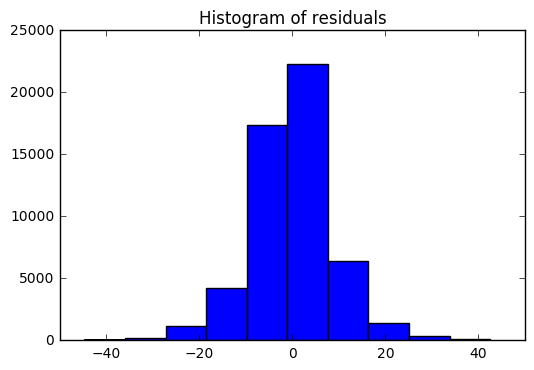

In [51]:
#Skipped code
plt.hist(model.summary.residuals.rdd.flatMap(lambda x:x).collect())
plt.title('Histogram of residuals')

<font color=blue>
Plot estimated coefficients. <br>
Enter code in the following cell

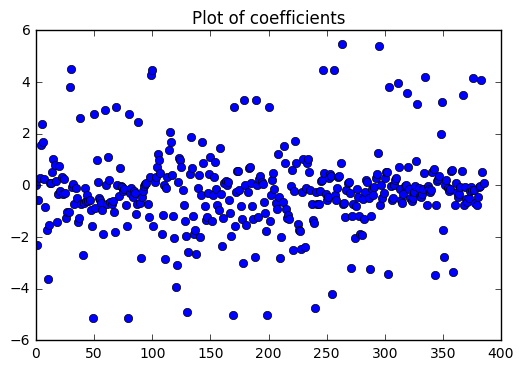

In [56]:
#Skipped code
plt.plot(model.coefficients,'o')
plt.title('Plot of coefficients')